<a href="https://colab.research.google.com/github/Swetha-angirekula/Quantumchem/blob/main/h2vqe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade --force-reinstall "h5py>=3.8.0" pennylane pennylane-qchem scipy numpy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 4.2 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of pennylane-qchem to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.7/109.7 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 63.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 67.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.3/53.3 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.2/35.2 MB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB

Number of qubits: 4
Number of Hamiltonian terms: 15
Tracked Energy: -1.116759
Step 0, Params norm: 0.018121
Step 0: Energy = -1.116759 Hartree
Tracked Energy: -1.119913
Tracked Energy: -1.122587
Tracked Energy: -1.124853
Tracked Energy: -1.126772
Tracked Energy: -1.128397
Tracked Energy: -1.129772
Tracked Energy: -1.130935
Tracked Energy: -1.131918
Tracked Energy: -1.132750
Tracked Energy: -1.133453
Step 10, Params norm: 0.136153
Step 10: Energy = -1.133453 Hartree
Tracked Energy: -1.134047
Tracked Energy: -1.134550
Tracked Energy: -1.134974
Tracked Energy: -1.135333
Tracked Energy: -1.135636
Tracked Energy: -1.135892
Tracked Energy: -1.136108
Tracked Energy: -1.136291
Tracked Energy: -1.136445
Tracked Energy: -1.136575
Step 20, Params norm: 0.187131
Step 20: Energy = -1.136575 Hartree
Tracked Energy: -1.136685
Tracked Energy: -1.136778
Tracked Energy: -1.136857
Tracked Energy: -1.136923
Tracked Energy: -1.136979
Tracked Energy: -1.137027
Tracked Energy: -1.137067
Tracked Energy: -1.13

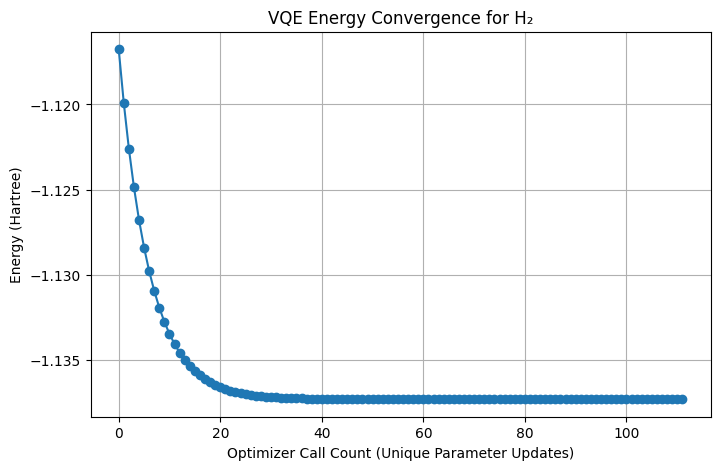

In [ ]:
import pennylane as qml
from pennylane import qchem
from pennylane import numpy as np
import matplotlib.pyplot as plt

# Constants
ANGSTROM_TO_BOHR = 1.8897259886

# Define H2 molecule symbols and coordinates (converted to Bohr units)
symbols = ["H", "H"]
coordinates = np.array([
    [0.0, 0.0, 0.0],
    [0.0, 0.0, 0.74 * ANGSTROM_TO_BOHR],  # bond length in Bohr (~0.74 Å)
])

# Create Molecule object with basis set
molecule = qchem.Molecule(
    symbols=symbols,
    coordinates=coordinates,
    charge=0,
    mult=1,
    basis_name="sto-3g"
)

# Number of active electrons and orbitals for H2
active_electrons = 2
active_orbitals = 2

# Build Hamiltonian
hamiltonian, num_qubits = qchem.molecular_hamiltonian(
    molecule,
    active_electrons=active_electrons,
    active_orbitals=active_orbitals
)

print("Number of qubits:", num_qubits)
print("Number of Hamiltonian terms:", len(hamiltonian))

# Prepare Hartree-Fock state
hf_state = qchem.hf_state(active_electrons, num_qubits)

# Get single and double excitations
singles, doubles = qchem.excitations(active_electrons, num_qubits)

# Convert excitations to wire format
s_wires, d_wires = qchem.excitations_to_wires(singles, doubles)

# Define quantum device
dev = qml.device("default.qubit", wires=num_qubits)

from pennylane.templates import UCCSD



# Define VQE circuit
@qml.qnode(dev)
def circuit(params):
    UCCSD(params, wires=range(num_qubits), s_wires=s_wires, d_wires=d_wires, init_state=hf_state)
    return qml.expval(hamiltonian)

# Initialize parameters
optimizer = qml.GradientDescentOptimizer(stepsize=0.1)
params = np.zeros(len(s_wires) + len(d_wires), requires_grad=True)

# Variables to track energy convergence
previous_params = None
energy_progress = []

def store_intermediate_result(params, energy):
    global previous_params
    if previous_params is None or not np.allclose(previous_params, params):
        energy_progress.append(energy)
        previous_params = params.copy()
        print(f"Tracked Energy: {energy:.6f}")

# Optimization loop with tracking
max_iters = 120
for n in range(max_iters):
    params, energy = optimizer.step_and_cost(circuit, params)
    store_intermediate_result(params, energy)
    if n % 10 == 0:
        print(f"Step {n}, Params norm: {np.linalg.norm(params):.6f}")
        print(f"Step {n}: Energy = {energy:.6f} Hartree")

print("Final VQE energy (Hartree):", energy)

# Exact diagonalization for comparison
Hmat = qml.matrix(hamiltonian)
eigvals, _ = np.linalg.eigh(Hmat)
print("Exact ground state energy (Hartree):", np.min(eigvals))

# Plot energy convergence
plt.figure(figsize=(8, 5))
plt.plot(range(len(energy_progress)), energy_progress, marker='o')
plt.xlabel("Optimizer Call Count (Unique Parameter Updates)")
plt.ylabel("Energy (Hartree)")
plt.title("VQE Energy Convergence for H₂")
plt.grid(True)
plt.show()


In [ ]:
!pip install pennylane fastapi uvicorn nest_asyncio pyngrok


In [ ]:
from pyngrok import ngrok

NGROK_AUTH = "32SGLpLBOgcnF33mQkZbwFRSYQy_4PRBYDq2xFTPjy7sFKk2k"   # <--- put your token here
ngrok.set_auth_token(NGROK_AUTH)
